# In this notebook we will do binary classification on the dataset of titanic.
## The following topics of statistics will be used in this notebook
- Scatterplot
- Data visualization
- Normal distribution
- Regression analysis
- Z-scores
- Standard deviation
- Normalization
- Feature selection
- T-test
- ANOVA
- Correlation matrix
- PCA
- Bias and reliability
### The goal of this notebook is to see if PCA has a correlation to the accuracy of the model


# Imports and loading dataset

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the Titanic dataset
titanic_df = pd.read_csv("titanic_data.csv")

# Display the first few rows of the dataset
print(titanic_df.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


### Checking for missing values

In [3]:
# Check for missing values
print(titanic_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Replacing missing values

In [4]:
# Replace NaN values in 'Age' column with the mean age
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

# Replace NaN values in 'Cabin' column with a label to indicate no cabin assigned
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('No Cabin')

# Encode 'Cabin' column
titanic_df['Cabin_Code'] = pd.factorize(titanic_df['Cabin'])[0]

# Deletion - remove rows with missing values
titanic_df.dropna(inplace=True)

# Check for missing values
print(titanic_df.isnull().sum())

# Print DataFrame head with only the changed features
print(titanic_df[['Age', 'Cabin', 'Cabin_Code']].head())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_Code     0
dtype: int64
    Age     Cabin  Cabin_Code
0  22.0  No Cabin           0
1  38.0       C85           1
2  26.0  No Cabin           0
3  35.0      C123           2
4  35.0  No Cabin           0


### One hot encoding


In [5]:
# One-hot encoding for categorical variables
titanic_df = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked'])

# Data visualization

### Scatterplot
A scatterplot is a type of data visualization that is used to display values for two variables for a set of data. The purpose of a scatterplot is to observe relationships or correlations between the two different variables. It allows us to see if an increase in one variable corresponds to an increase in the other variable, or if it leads to a decrease instead. It can also help in identifying trends, patterns, and outliers within the data.

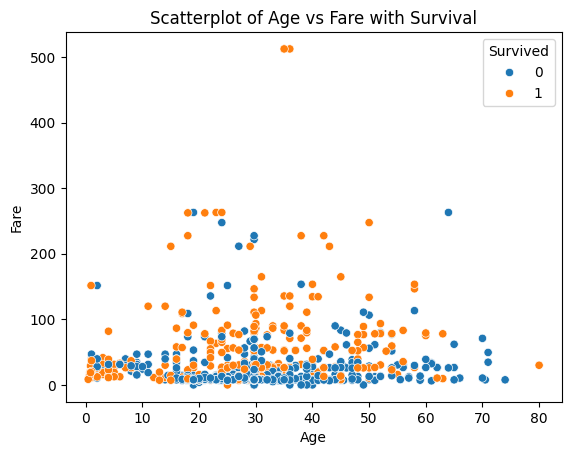

In [6]:
# Scatterplot of age vs fare with survival as hue
sns.scatterplot(data=titanic_df, x='Age', y='Fare', hue='Survived')
plt.title('Scatterplot of Age vs Fare with Survival')
plt.show()

The scatterplot shows the relationship between age and fare, color-coded by survival status. There is no clear pattern or correlation visible between age, fare, and survival status, with most data points clustered at the lower fare range.

## Pairplot

Since we dont see any correlation in this plot it raised the question if there is any correlation with surviving the titanic. We will use a pairplot to find the anwer.

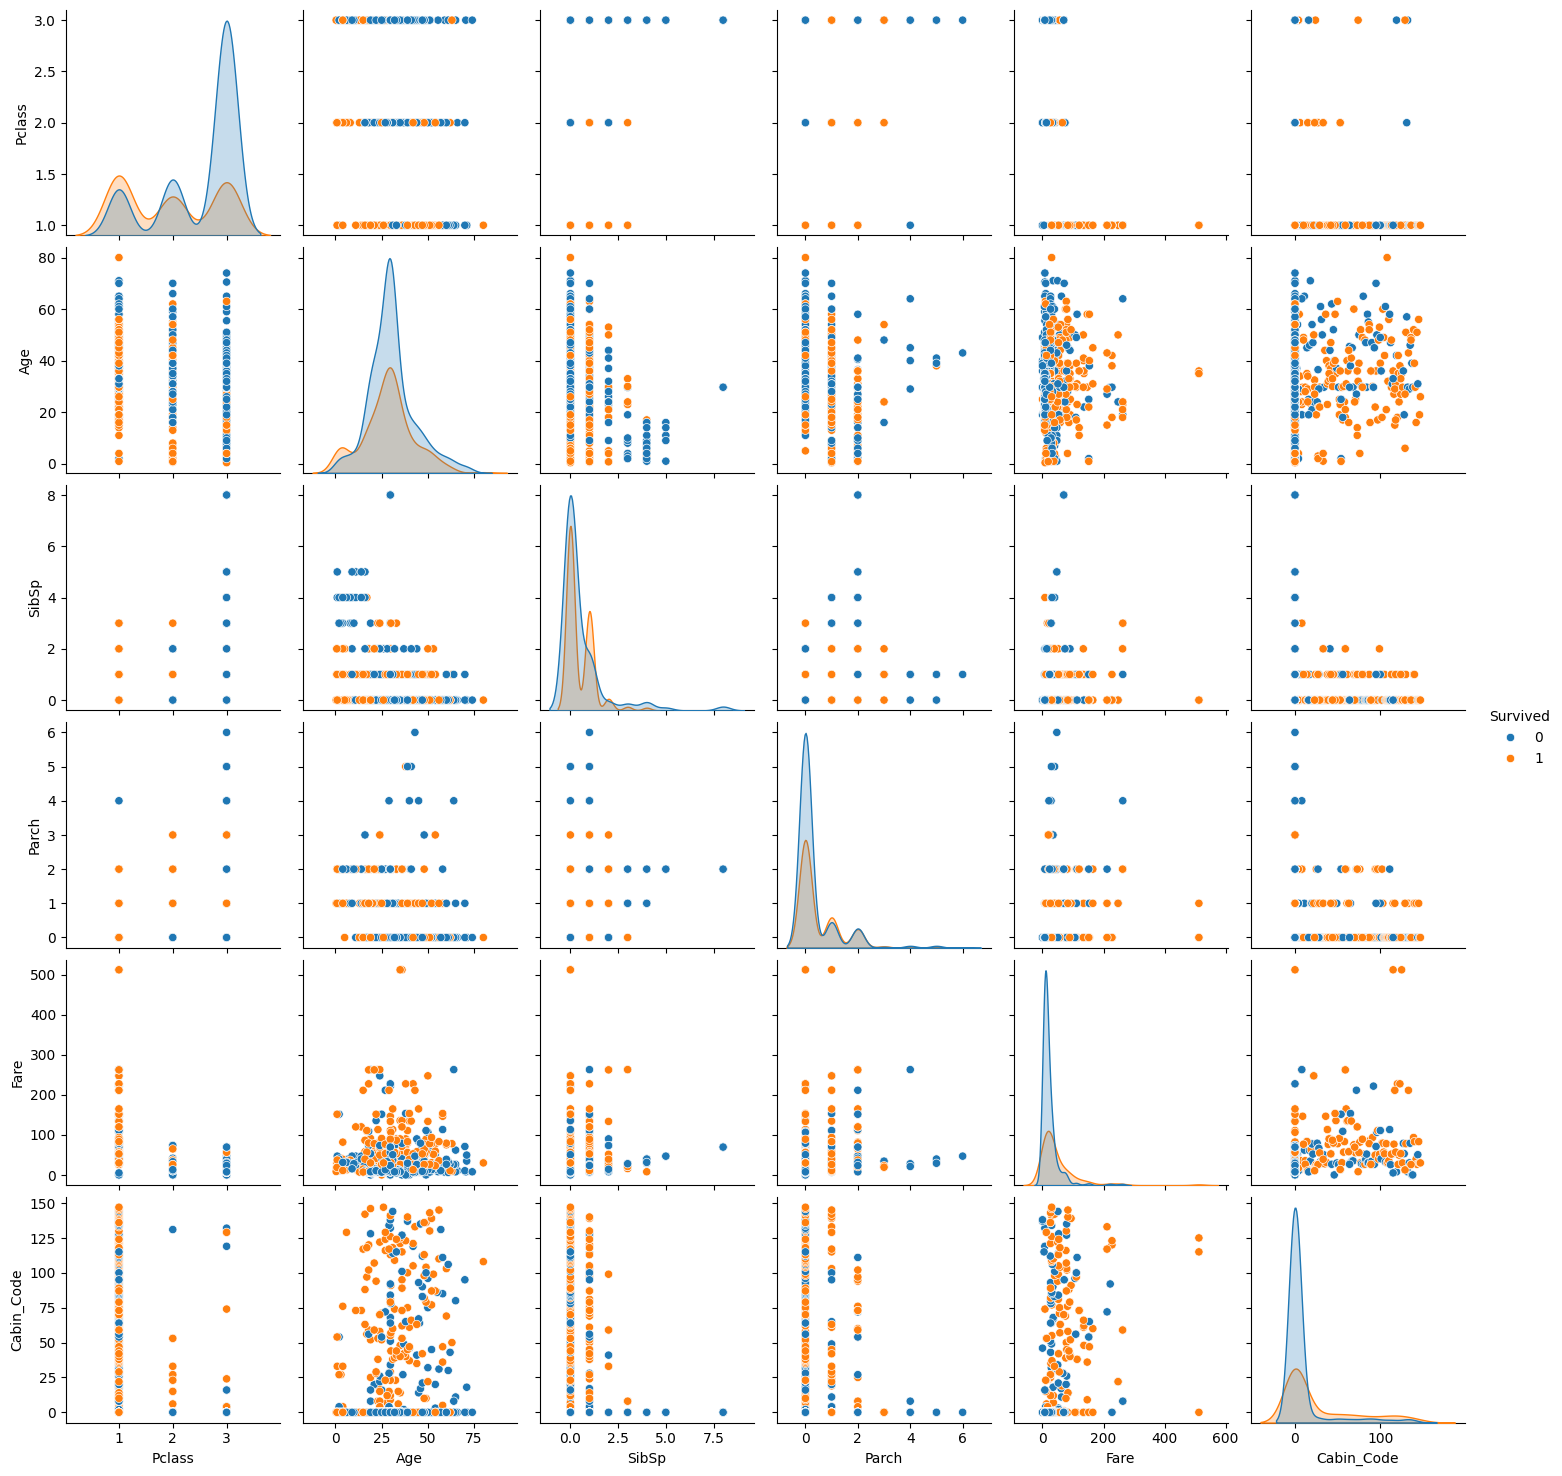

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'titanic_df' is your DataFrame

# Define columns to include in the pairplot
columns_to_include = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_Code']

# Create the pairplot
sns.pairplot(titanic_df[columns_to_include], diag_kind='kde', hue='Survived')
plt.show()


### Histogram
A histogram is a graphical representation used to show the distribution of a single variable in a data set. It helps identify the central tendency, variability, and asymmetry of the data, as well as any outliers. The x-axis represents data intervals, and the y-axis represents frequency of data points in each interval.

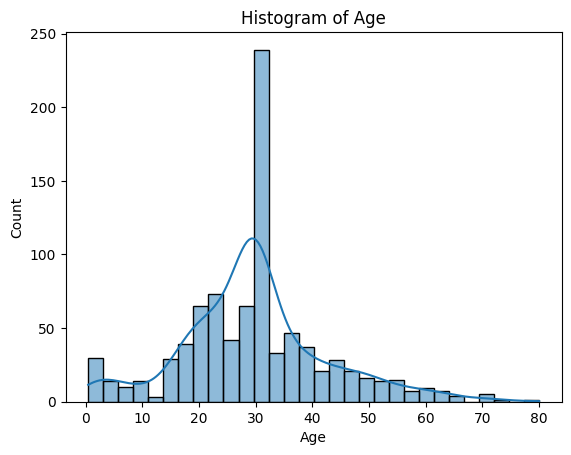

In [8]:

# Histogram of age
sns.histplot(titanic_df['Age'], kde=True)
plt.title('Histogram of Age')
plt.show()

The histogram shows a normal distribution of ages, with the most frequent age being around 30. This indicates that the data is symmetrically distributed around this peak, which is a characteristic of a normal distribution. This suggests that the age data follows a typical pattern where most of the values are close to the mean (30 in this case), with fewer values farther away.

### Boxplot
A boxplot is a graphical representation that shows the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It's useful for identifying outliers, variability, and comparing distributions between different data sets.

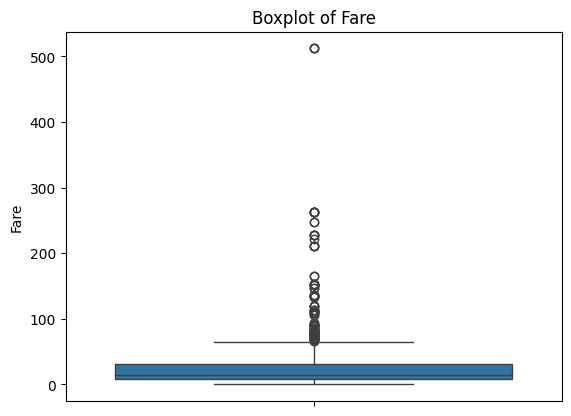

In [9]:
# Boxplot of fare
sns.boxplot(y='Fare', data=titanic_df)
plt.title('Boxplot of Fare')
plt.show()

The boxplot of fare data shows that most fares are clustered around the lower end, with a median below 100. However, there are several outliers indicating fares significantly higher than the majority, with the highest reaching up to 500. This suggests a wide range of fare prices with a few extreme values.

### Removing outliers
The outliers in the 'Fare' column were removed using the Interquartile Range (IQR) method.

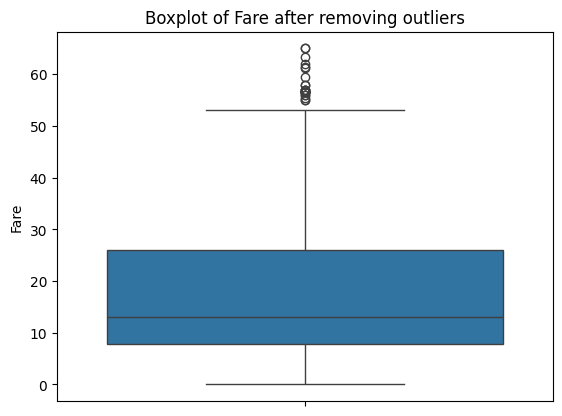

In [10]:
#Removing outliers
Q1 = titanic_df['Fare'].quantile(0.25) 
Q3 = titanic_df['Fare'].quantile(0.75) 
IQR = Q3 - Q1 
titanic_df = titanic_df[~((titanic_df['Fare'] < (Q1 - 1.5 * IQR)) | (titanic_df['Fare'] > (Q3 + 1.5 * IQR)))]

#Boxplot after removing outliers
sns.boxplot(y='Fare', data=titanic_df) 
plt.title('Boxplot of Fare after removing outliers') 
plt.show()

The boxplot of fare data after removing outliers shows a more concentrated distribution of fares, with the majority ranging from approximately 10 to 30. However, there are still some potential outliers above 50. Compared to the previous boxplot, this graph indicates a more consistent fare range after outlier removal. This suggests that the extreme fare values in the previous plot were indeed outliers and their removal has led to a more typical fare distribution.

### Z-scores
Normalization using Z-scores is a process that rescales data to have a mean of 0 and a standard deviation of 1. It's calculated using the formula:
- Z = (X - μ) / σ

Where:
- Z is the Z-score,
- X is the value of the data point,
- μ is the mean of the dataset, and
- σ is the standard deviation of the dataset.

In [11]:
# Normalization using Z-scores
titanic_df['Age_Zscore'] = stats.zscore(titanic_df['Age'])
print(titanic_df[['Age', 'Age_Zscore']].head())

         Age  Age_Zscore
0  22.000000   -0.556219
2  26.000000   -0.243027
3  35.000000    0.461654
4  35.000000    0.461654
5  29.699118    0.046606


### T-Tests
Feature selection using t-tests is a method to select important variables for a model. T-tests compare the means of two groups to see if they're statistically different. If the means of a feature for each class in a binary classification problem are significantly different, that feature is likely important for the model.

In [12]:
# Feature selection using t-tests
survived_age = titanic_df[titanic_df['Survived'] == 1]['Age']
not_survived_age = titanic_df[titanic_df['Survived'] == 0]['Age']
t_statistic, p_value = stats.ttest_ind(survived_age, not_survived_age)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: -3.3970910567589305
P-value: 0.0007158890974813489


The small p-value indicates that the difference in means observed is statistically significant, and the negative t-statistic suggests the first group's mean is lower than the second's.

### ANOVA
ANOVA, short for Analysis of Variance, is a statistical method used to compare the means of three or more groups to determine if there are any statistically significant differences between them. It's commonly used in experiments or studies where the impact of different conditions on a response variable is being investigated.

In [13]:
# ANOVA (Analysis of Variance)
# Perform ANOVA to test for significant differences in age among different passenger classes
anova_result = stats.f_oneway(titanic_df[titanic_df['Pclass'] == 1]['Age'],
                               titanic_df[titanic_df['Pclass'] == 2]['Age'],
                               titanic_df[titanic_df['Pclass'] == 3]['Age'])
print("ANOVA p-value:", anova_result.pvalue)

ANOVA p-value: 3.655704056311093e-23


The extremely small ANOVA p-value indicates there are significant differences between the group means in the dataset.

### Correlation Matrix
A correlation matrix is a table that shows the correlation coefficients between many variables. Each cell in the table shows the correlation between two variables. It is used to summarize data and find relationships between variables, as a high correlation can indicate a potential predictive relationship.

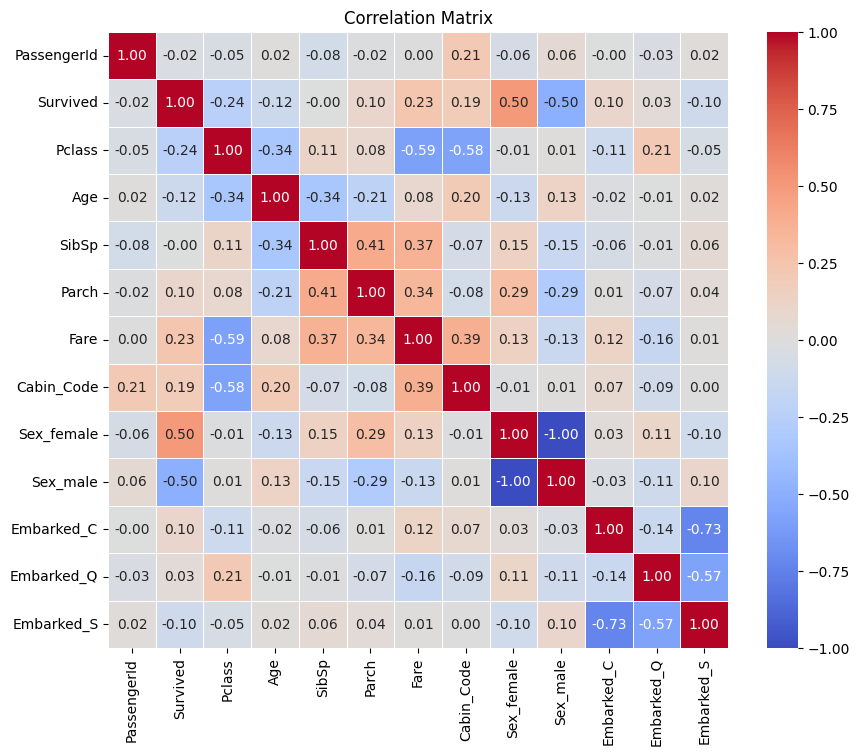

In [22]:
# Correlation Matrix
# Calculate the correlation matrix
correlation_matrix = titanic_df.drop(['Name', 'Ticket', 'Cabin', 'Age_Zscore'], axis=1).corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


The features that have a correlation with survival are “Fare”, "Cabin_Code" and “Sex_female”. These features show a positive correlation, meaning as these values increase, the chance of survival also increases. On the other hand has "Pclass" a negative correlation, so the chances of survival decrease.

### PCA
PCA, or Principal Component Analysis, is a statistical technique used in data analysis for dimensionality reduction. It transforms a large set of variables into a smaller one, while retaining most of the original data's variation. This is done by creating new uncorrelated variables (principal components) that successively maximize variance. It's commonly used in exploratory data analysis and for making predictive models.

In [23]:
# Splitting dataset for PCA
X = titanic_df.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Logistic Regression
Logistic regression is a statistical model used in machine learning for binary classification problems. It predicts the probability of an event occurring by fitting data to a logistic function. Hence, its output values lie between 0 and 1, which can be interpreted as the probability of a given sample belonging to a particular class. It's widely used in various fields such as medical, social sciences, and machine learning.

In [25]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)
y_pred = logreg.predict(X_test_pca)

### Bias and Reliability
Bias is a systematic error that leads to inaccurate results. Reliability refers to the consistency of a measure. Ideally, measurements should be both accurate (unbiased) and consistent (reliable), but a measure can be reliable without being unbiased, and vice versa.

In [26]:
# Define a function to calculate bias
def calculate_bias(predictions, actual):
    return np.mean(predictions) - np.mean(actual)

# Define a function to calculate reliability
def calculate_reliability(predictions, actual):
    return np.var(predictions) / (np.var(predictions) + np.var(actual))

# Calculate bias and reliability for the logistic regression model
bias_lr = calculate_bias(y_pred, y_test)
reliability_lr = calculate_reliability(y_pred, y_test)

print('Bias of Logistic Regression model:', bias_lr)
print('Reliability of Logistic Regression model:', reliability_lr)

Bias of Logistic Regression model: -0.10967741935483871
Reliability of Logistic Regression model: 0.4579688094332446


The Logistic Regression model has a slight negative bias and its reliability score is approximately 0.45, indicating the model's predictions are not very consistent.

### Confusion Matrix
A confusion matrix is a table used in statistics and machine learning to measure the performance of a classification model. It contains information about actual and predicted classifications done by the model. It's composed of four elements: true positives, true negatives, false positives, and false negatives. These elements help calculate important metrics like accuracy, precision, recall, and F1 score.

In [27]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.6967741935483871
Confusion Matrix:
[[80 15]
 [32 28]]


The model correctly predicted 70% of the outcomes, but it often failed to identify passengers who actually survived, indicating room for improvement.

# All features VS PCA features

In [28]:
# Voorspel een uitkomst met behulp van alle features
X_all = titanic_df.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y_all = titanic_df['Survived']

# Train-test split voor het model met alle features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Logistic Regression op alle features
logreg_all = LogisticRegression()
logreg_all.fit(X_train_all, y_train_all)
y_pred_all = logreg_all.predict(X_test_all)

# Voorspel dezelfde uitkomst met behulp van een aantal componenten na PCA
scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

pca_all = PCA(n_components=X_train_all_scaled.shape[1])  # behoudt alle componenten voor vergelijking
X_train_pca_all = pca_all.fit_transform(X_train_all_scaled)
X_test_pca_all = pca_all.transform(X_test_all_scaled)

logreg_pca = LogisticRegression()
logreg_pca.fit(X_train_pca_all, y_train_all)
y_pred_pca = logreg_pca.predict(X_test_pca_all)

# Model evaluatie voor beide modellen
accuracy_all = accuracy_score(y_test_all, y_pred_all)
accuracy_pca = accuracy_score(y_test_all, y_pred_pca)

# Uitkomsten vergelijken en conclusies trekken
print('Accuracy (alle features):', accuracy_all)
print('Accuracy (na PCA):', accuracy_pca)


Accuracy (alle features): 0.7677419354838709
Accuracy (na PCA): 0.7548387096774194


c:\Users\joeyw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Conclusion
As expected accuracy decreases when PCA removes certain features. 
These features might have a really small impact on the results but it is still some impact.
When you remove these features it is no longer possible to gather knowledge out of it and it is not able to predict on those values